# Deep Learning for Prostate Cancer Prediction

This notebook is the documentation which covers the implementation of a feedforward deep architecture nerual network to classify prostate cancer. 

## Neural Networks & Deep Learning
Neural Networks are machine learning models which have become increasingly popular in recent days for modelling complex systems. The idea behind neural nets can be somewhat traced back to the architecture of the brain, however arguably there are a large number of dissimilarities. Essentially neural networks are a number of models (nodes) layed out on computation graph form and each of the inputs are fed successively to each of these nodes (also called neurons). Indepth explanation of networks is beyond the scope of this document. If you are not familiar with neural networks, see https://en.wikipedia.org/wiki/Artificial_neural_network. Note this is a feed forward implemntation only. <br />
Deep learning is a recent (popularised recently) architectural scheme for neural networks. The computation nodes discussed above are generally arranged in layers. As apposed to shallow architecture, deep architecture involves having multiple layers before reaching the output of the network. You can learn more about deep learning at https://en.wikipedia.org/wiki/Deep_learning.

## Prostate Cancer Data 
The prostate cancer dataset is a 3000 observation dataset containing 4 level classification of prostate cancers. The entire dataset is numeric (with the response variable being a 4 level factor). The features are all measurements rounded to the nearest integer. See the exploratory data analysis for more information on this.

## How this notebook works.
Given that this is a deep learning notebook, it is unlikely that you want to go through the trainng phase. The training phase takes some time to run (depending on hardware ofcourse). None the less all the training code is available in the notebook. In the cell below, the variable named **isRetrainAllowed** is set to FALSE. If you would like to retrain, please set this variable to TRUE. Since networks are sensitive to initialisation, you may return different results to what has been trainied before.

### Deep Learning Model Architecture
We will be using the **h2o** library for the development of our deep learning models. This is a special environment which allows multi threaded learning for neural networks. This means that all models are of class h2o. When you want to test it on your validation set, you will not be able to simply call the **base::predict** function. 
We have defined a **predict.deep(dataset)** method for your use with the dataset. You may ask, why ? There are three reasons.

1. First the h2o library calls a special h2o.predict function which can talk to objects of type h2o. Our model will inherit from this class. <br />
2. The featureset needs to inherit from class h2o as well, so that some parallel processing may occur. <br />
3. This model takes engineered features, that is, the orignal features get transformed prior to being fed into the predictive model. <br />

### Libraries You Need To Run (Among other things)
This deep learning model has been trained in h2o Version 3.10.0.10. All models are saved from this version. For some reason, h2o has no backward compatibility. I'm serious, NO means absolutely nothing. So you need to install h2o version 3.10.0.10 even just to load the saved models. <br />
You also need the **deepModel.h2o** file to be in the folder of the notebook. This actually contains our neural network model. When you run the predict.deep(dataset) method, it'll make a call to load this file into memory and it'll pass your dataset into the model to make predictions. We will discuss in further detail inside the predict.deep method how it all works. <b4 />
The r script file **utilities.r** and **fe.r** are both required. These contain some utility and feature engineering functions which help transform or develop some new features using simple rules. 

In [1]:
## Set this to true if you want to retrain the deep learning model.
isRetrainAllowed <- FALSE
if(isRetrainAllowed){
    print("Warning: Model will retrain.")
} else{
    print("Skipping model training and loading existing model.")
}

[1] "Skipping model training and loading existing model."


In [2]:
## Required libraries. 
require(h2o)
require(ggplot2)
require(sqldf)
require(caret)
require(RSQLite)
require(gsubfn)
require(proto)

source("../utilities.r") # Utility functions and helpers.
source("../FE.r") # Feature engineering functions.

Loading required package: h2o
Warning message:
: package 'h2o' was built under R version 3.3.2Loading required package: statmod
Warning message:
: package 'statmod' was built under R version 3.3.1
----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc

Loading required package: ggplot2
Loading required package: sqldf
Warning message:
: package 'sqldf' was

## Feature Engineering

Bulk of the work for the deep learning model has happend in the feature engineering section. As discussed in the exploratory data analysis, the dataset is extremely non linear. The priniciple component analysis showed that that random scattering of variables with no distinct groups. This is probably a good sign that there will need to be some transformations done on the data and added as features. In order to keep simplicity, all the feature engineering happens in a pipeline. This is done for 2 reasons. Our predict.deep function can mimic our feature engineering and take the users dataset and do the trasnformation in function and also it makes the trasnformations much easier to follow. 

In [3]:
# Read in the original dataset.
dt_ <- read.csv("prostate.csv")

# Look for some near zero variance predictors from the original dataset.
nzv <- caret::nearZeroVar(dt_[,- c(1,ncol(dt_))],saveMetrics = TRUE)
nzv

,freqRatio,percentUnique,zeroVar,nzv
ATT1,1.183066,0.300000,0.000000,0.000000
ATT2,1.2265060,0.3333333,0.0000000,0.0000000
ATT3,1.173611,0.300000,0.000000,0.000000
ATT4,1.139908,0.300000,0.000000,0.000000
ATT5,1.15625,0.30000,0.00000,0.00000
ATT6,1.1149425,0.3333333,0.0000000,0.0000000
ATT7,1.1108647,0.3333333,0.0000000,0.0000000
ATT8,1.3664921,0.3333333,0.0000000,0.0000000
ATT9,1.1131640,0.3333333,0.0000000,0.0000000
ATT10,1.2668329,0.3333333,0.0000000,0.0000000


We can see that we don't really have any zero variance predictors. Also all the features seem to have only about 30% unique data points out of the entire data set. The most frequent to the second most frequent value also seems to be spread across the feature space from around 1.2 to 1.1. <br />
This shows that the data is quite spread out. Unlikely that the features themselves would do anything.<br />

### Training and Testing Set Generation
Before move any further, let's generate a test and training set for our models to train on and later validate how well the model generalized. <br />
To accomplish this we are going to use our utilities script. In this script the function PrepareTraining is what will be called.
This function is essentially a wrapper function to the caret package's createDartaPartition method. <br />
The added functionality includes, it drops the ID column, and forces the response variable (Result) to take a factor form. The split also ensures that the training set response distribution and the test set response distribution is similar. Given that we have unbalanced classes, this is very important. The function returns a list, with embedded training and testing dataframes.

In [4]:
training <- Udf.Utilities.PrepareTraining(dt_)$training
testing <- Udf.Utilities.PrepareTraining(dt_)$testing

### Step 1 :: Centering & Scaling 
Generally speaking, most algorithms, especially neural networks like 0 centered and scaled data. Why ? I don't know.
To do this we are going to use a method called preProcess from the caret package. This is actually a robust method to apply center and scaling using the training set and apply the same scaling matrix to any unseen data. We will also input a YeoJohnson transformation as well.

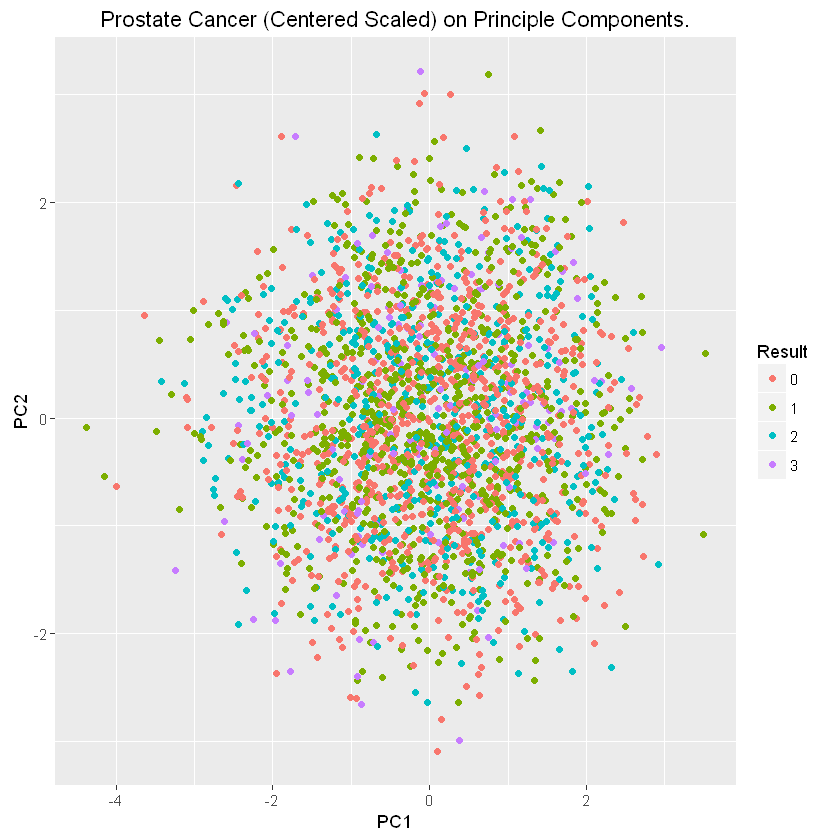

In [5]:
# Get the pre processor.
fe.PreProcessor <- caret::preProcess(training,method = c("center","scale","YeoJohnson"))

# We don't actually use this preprocessor in our predict.deep method but this show's you how the code works.
# Use the preprocessor to transform the training and the test dataset. This preprocessor model will be used to transform all unseen data as well.
tr.csyj <- predict(fe.PreProcessor,training) # training set.
ts.csyj <- predict(fe.PreProcessor,testing) # testing set.

# Let's visualise the dataset using smoe principle component analysis to get the two major axis. We will again call on a wrapper from the utilities script to do the principle component analysis for us. Inside the Udf.Utilities.Prcomp method is a simple call to stats::prcomp method. 
ggplot(Udf.Utilities.Prcomp(tr.csyj[,-ncol(tr.csyj)],nComps = 2)$components,aes(PC1,PC2,color = tr.csyj$Result)) + geom_point() + scale_color_discrete("Result") + ggtitle("Prostate Cancer (Centered Scaled) on Principle Components.")

We can see that there are no really distinct cluster groups. This is probably not a good indicator of predictability, there is absolutetly no visibility of class separation at all. There is also somewhat scattering to the outside as well, let's try using a spatial sign transform to project it radially outwards to see if we can improve the performance of the PCA.

### Step 2 :: Spatial Sign Transform
Spatial sign transforms are usually used to target outliers. But in this case, I just tried it randomly while I was frustrated about model performance, so voila. 

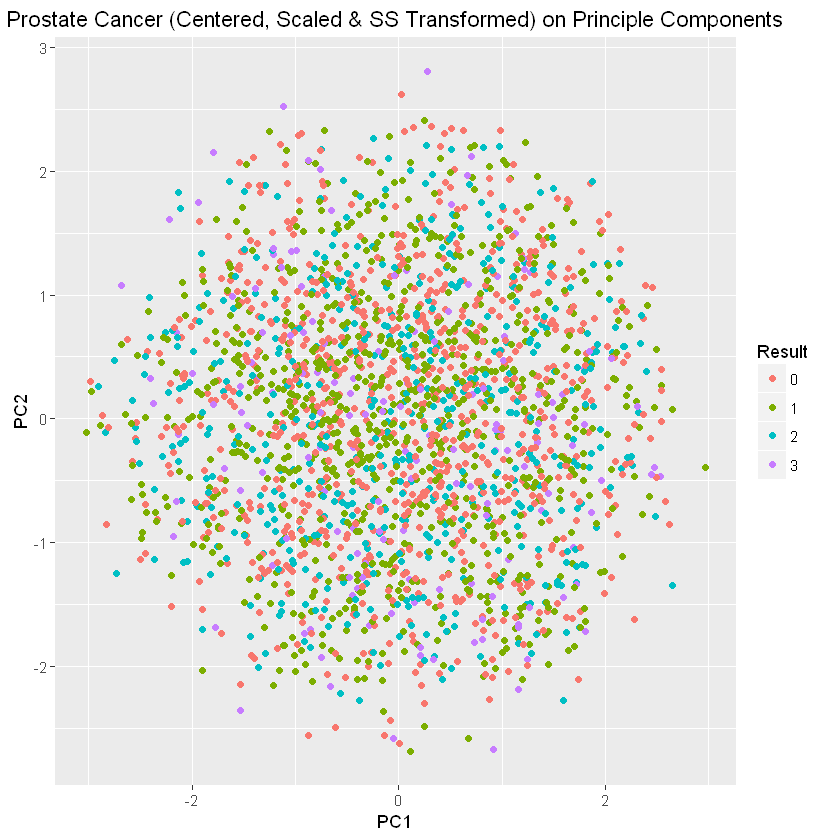

In [6]:
tr.csyj.ss <- as.data.frame(caret::spatialSign(tr.csyj[,-ncol(tr.csyj)]))
ts.csyj.ss <- as.data.frame(caret::spatialSign(ts.csyj[,-ncol(ts.csyj)]))

# Let's revisualise to see if the PCA has improved.
ggplot(Udf.Utilities.Prcomp(tr.csyj.ss,nComps = 2)$components,aes(PC1,PC2,color = tr.csyj$Result)) + geom_point() + scale_color_discrete("Result") + ggtitle("Prostate Cancer (Centered, Scaled & SS Transformed) on Principle Components")


Well, there isn't much improvement, but the data is less spread out, which is exactly what spatial sign does. 
We are going to use regularisation in our neural network, so it should automatically scale the parameters which are insiginificant down or to zero. Therefore we will bind any additonal transformations to the centered and scaled data. Let's call these binding objects as feed(s). So feed.training and feed.testing. We will hold out the label until we are at the final stage.
And yes, this is not the same as subsetting features (especially in these nonlinear models) but with the time constraint and the relatively poor computational power i have to make this model, my search grid couldn't be too big.

In [7]:
# Original data centered and scaled with a YeaJohnson transform.
feed.training <- tr.csyj[,-ncol(tr.csyj)]
feed.testing <- ts.csyj[,-ncol(tr.csyj)]  

# Bind the new data and redo column names
feed.training <- cbind(feed.training,tr.csyj.ss)
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="")

feed.testing <- cbind(feed.testing,ts.csyj.ss)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 3 :: Adding the PCA Results
So far we have just been using PCA to visualise the data set. But let's include the soem of the results from the PCA as extra features. This may give it some more of the description of featurespace from the linear model of PCA.

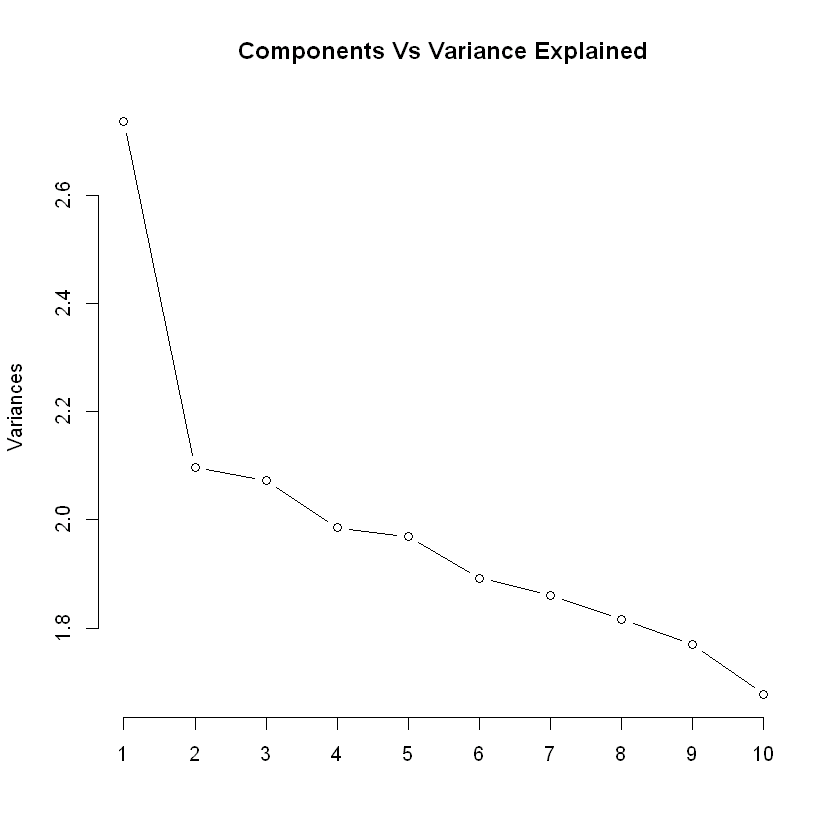

In [8]:
pcaModel_ <- Udf.Utilities.Prcomp(feed.training,nComp = ncol(feed.training))
# Look at the components and their explanation of the overall variance in the dataset.
plot(pcaModel_$prcompObj,"Components Vs Variance Explained",type = "l")

Looks like there is no 1 component which explains most of the variance. Remember our model is going to have l1 regularisation therefore it'll just simply scale the weights down to zero where variables don't actually help. So lets add the entire thing. <br />
It is important that we keep the same rotation that we learned from our training set over to the validation sets. So let's extract the rotation matrix and then multiply our validation set to get the rotated values. <br />

multiply the rotation by the matrix which is spatial sign transformed to get the next step.


In [10]:
tr.csyj.ss.pca <- pcaModel_$prcompObj$rotation * feed.training # matrix multiply the weights into the features.
feed.training <- cbind(feed.training,tr.csyj.ss.pca) # Bind the existing data.
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="") # Generalise feature names.

ts.csyj.ss.pca <- pcaModel_$prcompObj$rotation * feed.testing
feed.testing <- cbind(feed.testing,ts.csyj.ss.pca)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 4 :: Row Sum of Top 2 PCA
Another useful feature may be able to be captured by the top principle components. We will use the top 2 here. This was also added because I did some random testing and found this actually helped the mean accuracy go up. 

In [11]:
tr.csyj.ss.pca.sum <- rowSums((pcaModel_$prcompObj$rotation * tr.csyj.ss.pca)[,1:2])
feed.training <- cbind(feed.training,tr.csyj.ss.pca.sum)
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="")

ts.csyj.ss.pca.sum <- rowSums((pcaModel_$prcompObj$rotation * ts.csyj.ss.pca)[,1:2])
feed.testing <- cbind(feed.testing,ts.csyj.ss.pca.sum)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 5 :: Frequency Values of Features
Another useful feature is the number of counts of some of the variables and how the occur on the dataset. Given that everything is rounded to an integer, we can assume they are nearly categorical. Lets see how we do with this. We are calling on one of our utility functions, which essentiall does a count and joins it using the sqldf library.

In [12]:
tr.colsum <- my.f2cnt(training,"ATT1","ATT2")
feed.training <- cbind(feed.training,tr.colsum)
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="")

ts.colsum <- my.f2cnt(testing,"ATT1","ATT2")
feed.testing <- cbind(feed.testing,ts.colsum)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

Warning message:
: Quoted identifiers should have class SQL, use DBI::SQL() if the caller performs the quoting.

### Step 6 :: Scale and Center Everything
Once again, scale and center everything so that the NN gets nice values between 1 and -1.

In [13]:
feed.training <- scale(feed.training)
feed.testing <- scale(feed.testing)
# Rebind the labels.
feed.training <- as.data.frame(cbind(feed.training,training[,"Result"]))
colnames(feed.training)[ncol(feed.training)] <- "Result"
feed.training[,"Result"] <- as.factor(feed.training[,"Result"])
feed.testing <- as.data.frame(cbind(feed.testing,testing[,"Result"]))
colnames(feed.testing)[ncol(feed.testing)] <- "Result"
feed.testing[,"Result"] <- as.factor(feed.testing[,"Result"])

### Autoencoder.
Autoencoders are a non supervised learning implementation of neural networks. We are going to be using it as a non linear implementation of PCA. That is, reducing dimensionality of the dataset non linearly. We will use the reduced set of outputs as features to our NN supervised model.

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 minutes 56 seconds 
    H2O cluster version:        3.10.0.8 
    H2O cluster version age:    1 month and 22 days  
    H2O cluster name:           H2O_started_from_R_aaron_wsy057 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.75 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.0 (2016-05-03) 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


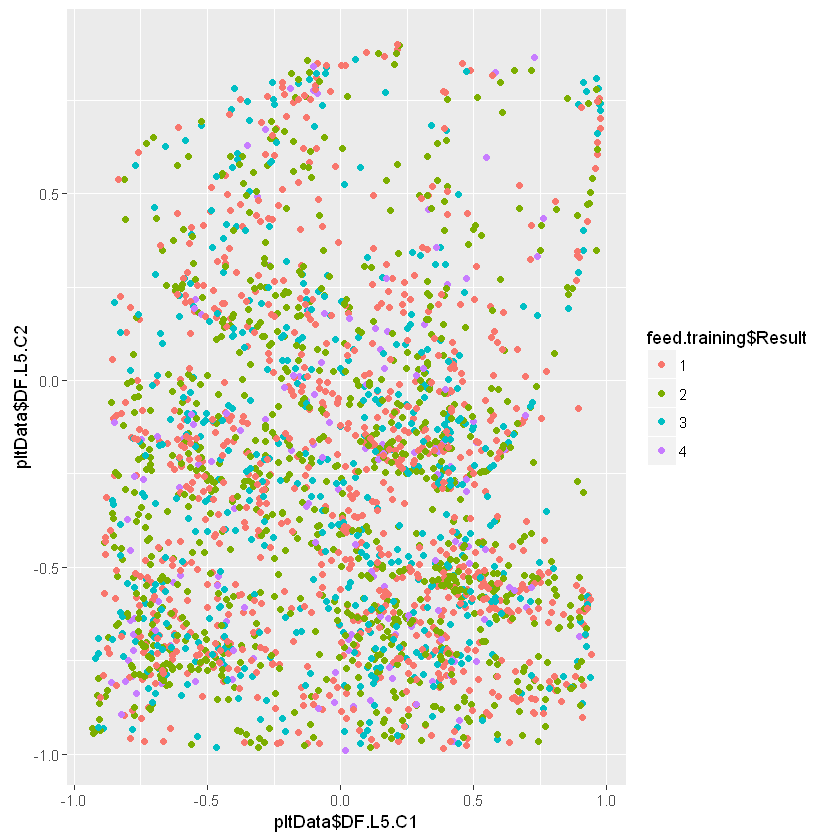

In [17]:
# Initialse h2o.
h2o.init(nthreads = -1)

# Cast the trainig and test sets as h2o objects.
h2_tr <- as.h2o(feed.training,"h2_tr")
h2_ts <- as.h2o(feed.testing,"h2_ts")


# Visualise using autoencoder.
AE <- h2o.deeplearning(
    x = 1:(ncol(feed.training) - 1),
    training_frame = h2_tr,
    hidden = c(33, 23, 13, 3, 2, 3, 13, 23, 33),
    epochs = 600,
    activation = "Tanh",
    autoencoder = TRUE,
    export_weights_and_biases = TRUE
)

# Visualise autoencoder output
tr_sup_ft <- h2o.deepfeatures(AE, h2_tr, layer = 5)
pltData <- as.data.frame(tr_sup_ft)


ggplot(pltData, aes(pltData$DF.L5.C1, pltData$DF.L5.C2, color = feed.training$Result)) + geom_point()

In [16]:
# Helper to bind features.
BindDeepFeatures <- function(features,weights){

    # Attach the autoencoder features.
    dFtMtx <- matrix(nrow = nrow(features),ncol = 13) # Genereate a container for the new features.

    ftMtx_ <- as.matrix(features) # Cast input as matrix.
    pb_ <- txtProgressBar(style = 3) # Progress bar.
    for(i in 1:nrow(ftMtx_)){

        # Drop down through teh layers.
        tmp__ <- weights[[1]] %*% ftMtx_[i,]
        tmp__ <- weights[[2]] %*% tmp__
        tmp__ <- weights[[3]] %*% tmp__

        tmp__ <- t(tmp__) # Transpose


        dFtMtx[i,] <- tmp__ # Concatenate
        setTxtProgressBar(pb_,i/nrow(ftMtx_))
        close(pb_)
    }

    boundMatrix_ <- cbind(ftMtx_,dFtMtx)

    return(as.data.frame(boundMatrix_))
}

### Step 7 :: Bind Autoencoder Output
We will simply read in the weights from a previous run, and wont't use the output from this autoencoder since it's very sensitive to the starting position. For every different autoencoder output we need to retrain our NN model downstream. 

In [18]:
# Read in the weights
ae.weights <- readRDS("AutoEncoderWeights.rds")

# Use the method we defined above to bind the features.
feed.training.deep <- BindDeepFeatures(feed.training[,-ncol(feed.training)],ae.weights)
feed.testing.deep <- BindDeepFeatures(feed.testing[,-ncol(feed.testing)],ae.weights)

  |                                                                      |   0%
  |                                                                      |   0%
  |======================================================================| 100%

Now we can just rebind the label and get it ready for analyisis.

In [19]:
# rebind the labels.
feed.training.deep <- as.data.frame(cbind(feed.training.deep,training[,"Result"]))
colnames(feed.training.deep)[ncol(feed.training.deep)] <- "Result"
feed.training.deep[,"Result"] <- as.factor(feed.training.deep[,"Result"])
feed.testing.deep <- as.data.frame(cbind(feed.testing.deep,testing[,"Result"]))
colnames(feed.testing.deep)[ncol(feed.testing.deep)] <- "Result"
feed.testing.deep[,"Result"] <- as.factor(feed.testing.deep[,"Result"])

## Cast as h2o object.
h2_tr <- as.h2o(feed.training.deep,"h2_tr")
h2_ts <- as.h2o(feed.testing.deep,"h2_ts")

  |======================================================================| 100%
  |======================================================================| 100%


## Training the Neural Network.
Neural networks are inherently difficult to train. They are prone to fast overfitting and the loss function is non convex with many local minima. So it's somewhat of a black art in getting it right. In this assignment alone i have built over 100 neural networks on a very very slow core i5.

In [ ]:
if(isRetrainAllowed){
    dl_8 <- h2o.deeplearning(# 37.5%
    x = 1:(ncol(h2_tr) - 1),
    y = ncol(h2_tr),
    training_frame = h2_tr,
    validation_frame = h2_ts,
    distribution = "multinomial",
    activation = "MaxoutWithDropout",
    hidden = c(400, 600, 400),
    l2 = 5e-5,
    epochs = 10,
    nfolds = 10,
    balance_classes = TRUE,
    input_dropout_ratio = 0.1,
    loss = "CrossEntropy",
    classification_stop = 0.45
)


prd_8 <- h2o.predict(dl_8, h2_ts)
prd_8 <- as.data.frame(prd_8)
sum(as.numeric(prd_8$predict) == as.numeric(feed.testing.deep$Result)) / 599
}

## The predict.deep method
Below is the implementation of the predict.deep method. the code comments will explain everything that happens.

In [9]:
predict.deep <- function(data,h2oModel = NULL) {
    
    # Input parameters.
    # data :: A dataframe of the input features. Does not take ID or Response variable.

    # Assert that input featurespace must be 10 wide.
    if (ncol(data) != 10) {
        stop("Input features do not match the prostate.csv feature length. Have you forgotton to remove ID and Result columns ?")
    }

    # Assert that h2o is available 
    require(h2o)
    require(caret)
    h2o.init(nthreads = -1)
    # Assert that h2o version is correct
    if (h2o.getVersion() != "3.10.0.8") {
        stop("You have a different version of H2O, get the version 3.10.0.8")
    }


    ## Start feature engineering.

    # Step 1 feature scaling and centering with preprocessor.
    fe.preProcessor <- readRDS("fePreProcessor.rds")

    tr.csyj <- predict(fe.preProcessor, data) # make prediction on new data.


    ## Step 2 :: Spatial Sign transform
    tr.csyj.ss <- as.data.frame(caret::spatialSign(tr.csyj))

    # Bind the new data and redo column names
    feed.training <- cbind(tr.csyj, tr.csyj.ss)
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "")

    ## Step 3 :: Add PCA results
    # Read in the model
    pcaModel_ <- readRDS("pcaModel.rds")

    tr.csyj.ss.pca <- pcaModel_$prcompObj$rotation * feed.training # matrix multiply the weights into the features.
    feed.training <- cbind(feed.training, tr.csyj.ss.pca) # Bind the existing data.
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "") # Generalise feature names.

    ## Step 4 :: Row sums of 2 PCA components.
    tr.csyj.ss.pca.sum <- rowSums((pcaModel_$prcompObj$rotation * tr.csyj.ss.pca)[, 1:2])
    feed.training <- cbind(feed.training, tr.csyj.ss.pca.sum)
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "")

    ## Step 5 :: Frequency values of features
    source("FE.r")
    tr.colsum <- my.f2cnt(data, "ATT1", "ATT2")
    feed.training <- cbind(feed.training, tr.colsum)
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "")

    # Step 6 :: Scale and center everything

    feed.training <- scale(feed.training)

    # Step 7 :: Bind autoencoder output

    # Read in the autoencoder weights
    ae.weights <- readRDS("AutoEncoderWeights.rds")

    # Helper to bind features.
    BindDeepFeatures <- function(features, weights) {

        # Attach the autoencoder features.
        dFtMtx <- matrix(nrow = nrow(features), ncol = 13) # Genereate a container for the new features.

        ftMtx_ <- as.matrix(features) # Cast input as matrix.
        for (i in 1:nrow(ftMtx_)) {

            # Drop down through teh layers.
            tmp__ <- weights[[1]] %*% ftMtx_[i,]
            tmp__ <- weights[[2]] %*% tmp__
            tmp__ <- weights[[3]] %*% tmp__

            tmp__ <- t(tmp__) # Transpose


            dFtMtx[i,] <- tmp__ # Concatenate
        }

        boundMatrix_ <- cbind(ftMtx_, dFtMtx)

        return(as.data.frame(boundMatrix_))
    }

    # bind features
    feed.training.deep <- BindDeepFeatures(feed.training, ae.weights)

    # Cast h2o object.
    h2_tr <- as.h2o(feed.training.deep, "h2_tr")

    # Get the neural network model or use passed model.
    if (is.null(h2oModel)) {
        mdl_ <- h2o.loadModel("DeepLearning_model_R_1480681170824_1")
    } else {
        mdl_ <- h2oModel;
    }

    pred <- as.data.frame(h2o.predict(mdl_, h2_tr)) # return predictions as dataframe.

    return(pred[,"predict"])
}

In [10]:
predict.deep(dt_[,c(-1,-ncol(dt_))])

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         18 minutes 35 seconds 
    H2O cluster version:        3.10.0.8 
    H2O cluster version age:    1 month and 22 days  
    H2O cluster name:           H2O_started_from_R_aaron_cuq053 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.55 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.0 (2016-05-03) 



Warning message:
: Quoted identifiers should have class SQL, use DBI::SQL() if the caller performs the quoting.

  |======================================================================| 100%
  |======================================================================| 100%


[1] 0 1 1 1 1 2 2 2 0 0 2 2 0 1 0 2 2 0 0 1 0 1 0 0 1 1 0 0 3 0 0 1 2 2 1 1 0
  [38] 0 1 2 0 1 1 1 2 2 1 2 1 1 2 0 1 1 1 0 1 1 2 1 2 2 2 0 1 0 1 2 0 0 0 2 0 2
  [75] 2 1 1 1 2 0 1 2 0 0 1 2 3 2 2 0 0 1 0 0 0 1 2 0 2 2 1 0 0 1 0 2 1 0 2 1 1
 [112] 1 0 0 0 2 2 0 0 1 0 0 0 2 2 0 1 1 2 2 0 2 1 2 1 0 2 0 0 1 2 0 0 0 0 0 2 2
 [149] 2 2 1 1 0 0 0 1 0 0 1 1 2 0 2 0 1 1 2 0 0 2 1 2 1 0 2 1 2 2 0 1 2 1 1 1 1
 [186] 2 1 3 2 0 0 1 1 0 0 0 0 0 0 2 1 0 2 0 2 1 0 1 0 0 1 2 1 2 1 2 2 1 1 1 1 0
 [223] 2 2 0 1 1 1 2 0 1 0 2 1 1 0 0 0 1 0 0 2 1 2 2 1 0 0 3 0 3 0 0 0 0 1 2 1 1
 [260] 3 0 0 2 2 0 1 0 2 0 2 0 1 2 1 1 2 0 2 1 0 0 0 1 1 2 2 2 0 0 1 0 2 1 2 0 1
 [297] 0 2 0 0 1 0 0 1 2 1 0 0 1 1 0 0 0 1 0 2 1 2 0 0 0 1 0 0 0 1 0 2 1 1 1 1 1
 [334] 2 1 0 1 0 2 0 0 2 0 1 0 1 2 0 1 0 0 1 2 0 1 2 2 1 1 2 1 0 1 0 0 2 0 0 1 0
 [371] 0 2 1 0 0 1 2 0 0 0 2 1 0 0 1 2 1 0 1 0 1 0 1 0 2 0 0 0 2 0 1 0 1 0 1 0 1
 [408] 0 0 0 2 0 0 1 0 2 0 1 2 2 1 0 2 0 0 0 2 0 0 0 0 0 2 2 1 1 0 0 0 2 0 0 0 1
 [445] 0 1 0 1 1 3 1 1 0 0 0 1 2 0 0 2 0 0 1 1 0 1 0 1 1 2 1 1 2 2 1 0 1 1 1 1 0
 [482] 0 1 2 0 0 1 2 2 1 1 1 0 1 0 1 0 0 1 1 0 1 0 2 2 2 1 0 1 1 0 0 2 1 1 0 1 2
 [519] 2 1 0 2 1 2 1 0 1 1 0 0 1 0 0 0 1 2 1 1 1 1 2 0 0 0 1 0 1 2 1 1 0 3 2 1 1
 [556] 0 1 0 0 2 3 0 1 0 0 0 1 0 0 1 2 0 0 0 2 1 0 0 0 2 2 0 1 0 0 1 0 0 1 0 0 2
 [593] 0 2 1 3 2 1 0 1 0 1 1 1 1 0 2 0 1 1 2 1 3 0 0 1 1 0 0 0 1 1 0 0 0 1 1 2 1
 [630] 0 1 1 1 2 1 0 1 0 0 0 0 2 0 2 0 2 2 0 0 0 1 1 0 0 0 1 0 2 0 2 1 0 0 2 1 0
 [667] 1 1 1 1 0 0 2 1 2 2 1 1 0 1 0 0 0 1 2 0 0 0 0 1 0 2 0 0 2 1 2 0 0 3 3 0 1
 [704] 2 1 0 0 0 1 1 0 1 1 1 2 1 0 0 2 2 0 0 3 1 1 1 3 0 1 0 0 0 2 0 2 1 0 0 0 1
 [741] 2 0 0 1 1 2 1 1 1 2 0 0 2 2 2 2 0 0 0 0 0 0 1 2 1 1 0 0 2 1 2 0 2 0 2 0 2
 [778] 2 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 3 0 1 2 0 0 0 1 1 0 1 1 0 0 1 1 1
 [815] 2 1 1 0 2 0 0 0 2 1 0 2 0 2 1 0 2 2 2 0 2 0 0 0 1 0 0 0 1 0 0 2 2 0 1 1 2
 [852] 0 0 1 1 0 0 0 0 2 0 2 0 2 0 0 1 1 1 1 0 0 0 2 0 0 0 0 1 0 0 0 1 0 2 2 1 0
 [889] 0 0 1 0 0 1 1 0 0 0 1 2 1 0 1 1 2 0 1 1 0 1 0 1 0 0 0 0 1 0 0 2 2 0 2 0 1
 [926] 1 2 1 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 2 2 2 0 0 0 1 0 1
 [963] 1 0 1 0 2 1 1 0 2 1 1 1 2 2 1 0 2 0 2 2 2 0 0 2 2 0 0 0 0 2 1 0 0 1 0 1 0
[1000] 0 1 1 1 0 1 0 1 0 0 1 2 2 0 1 0 0 1 0 0 2 0 0 0 1 0 1 0 0 0 2 0 1 0 0 2 0
[1037] 1 0 2 0 1 2 0 1 2 2 0 0 1 1 0 1 2 1 2 0 0 0 0 2 0 2 2 0 2 2 0 0 1 0 2 1 0
[1074] 0 0 0 1 2 0 2 0 0 0 2 0 0 0 1 1 0 0 2 1 0 2 2 2 2 2 0 1 2 1 2 1 2 0 0 2 0
[1111] 2 0 0 0 2 0 1 0 1 0 0 0 0 3 2 2 2 1 1 2 0 2 0 2 0 1 0 1 0 0 2 0 0 2 1 1 2
[1148] 2 2 0 2 0 2 0 1 0 2 0 1 2 1 0 1 2 0 0 2 1 2 0 0 0 0 0 0 1 0 1 0 2 0 1 0 0
[1185] 0 2 1 1 2 0 2 2 1 2 1 2 1 0 0 2 0 0 1 0 1 1 1 0 2 2 0 2 0 2 1 0 0 0 0 0 2
[1222] 1 0 0 0 0 2 1 2 0 1 2 0 0 1 0 1 2 0 1 0 0 1 0 1 0 0 1 2 2 0 2 2 1 1 1 2 1
[1259] 1 1 2 0 1 2 1 2 1 2 1 1 1 2 0 1 2 0 0 1 0 1 1 3 0 2 0 1 2 1 1 0 0 2 0 2 0
[1296] 2 2 0 2 2 0 0 2 2 2 0 2 0 2 1 1 0 2 0 2 0 1 3 3 1 0 0 1 2 1 1 0 2 1 0 0 1
[1333] 1 0 0 0 0 0 0 0 0 0 2 0 2 0 1 2 0 0 0 2 1 1 1 0 1 1 1 0 1 1 2 1 1 2 0 2 0
[1370] 0 1 2 1 1 0 0 1 1 0 0 2 1 1 1 0 0 2 0 1 2 1 0 0 0 1 1 0 2 2 0 0 0 0 1 0 2
[1407] 0 0 0 2 2 0 2 1 0 1 0 1 0 0 1 1 0 2 0 2 0 2 0 1 2 0 2 0 0 0 0 1 0 0 1 1 1
[1444] 0 0 2 0 0 1 0 1 0 1 1 1 1 2 2 0 0 1 0 1 0 2 2 0 1 2 1 2 0 0 1 0 0 0 2 1 0
[1481] 1 0 0 0 0 2 1 0 2 0 2 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 2 2 0 2 1 0 1 1
[1518] 2 2 0 0 0 1 0 0 1 1 0 0 0 0 0 3 1 2 0 1 1 2 2 1 0 0 0 2 1 0 0 0 1 2 2 0 0
[1555] 0 1 1 0 2 0 1 0 0 2 2 0 2 0 2 1 2 0 0 2 0 0 0 2 0 0 1 0 0 1 1 0 0 1 1 2 1
[1592] 1 1 0 1 1 0 0 2 2 1 1 0 0 0 3 1 0 1 1 1 2 2 0 1 2 1 0 0 2 0 1 1 0 1 2 1 0
[1629] 2 1 0 1 0 0 0 2 2 0 0 1 0 1 1 1 1 1 0 0 2 0 1 0 0 0 0 1 2 2 1 0 0 0 0 0 0
[1666] 1 0 0 1 1 1 2 1 0 1 0 1 0 0 1 0 0 2 1 1 2 2 0 2 2 1 2 2 0 1 0 0 1 0 2 1 0
[1703] 1 0 1 0 0 0 2 0 1 1 0 0 1 0 2 0 2 1 2 0 0 2 0 1 0 1 0 0 1 1 1 2 1 0 1 1 2
[1740] 1 2 0 2 1 2 2 0 2 1 0 0 2 0 2 0 1 2 1 0 0 0 0 0 0 1 0 2 2 0 2 1 1 1 1 0 2
[1777] 2 2 1 0 1 1 0 1 1 0 0 2 1 2 2 0 1 2 0 2 2 0 2 2 0 0 1 0 0 0 1 0 0 1 0 0 1
[1814] 2 2 0 2 0 1 2 1 0 0 1 1 1 0